<a href="https://colab.research.google.com/github/filip-koselski/quantum-internship-task4/blob/main/Task4_Quantum_Internship_UNet_NeuralNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install rasterio
!pip install pandas
!pip install geopandas
!pip install numpy
!pip install opencv-python
!pip install matplotlib
!pip install shapely

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.3 MB 1.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 5.2 MB/s 
     |████████████████████████████████| 16.7 MB 99 kB/s 
     |████████████████████████████████| 6.3 MB 50.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os

import rasterio
from rasterio.plot import reshape_as_image
import rasterio.mask
from rasterio.features import rasterize

import pandas as pd
import geopandas as gpd
from shapely.geometry import mapping, Point, Polygon
from shapely.ops import cascaded_union

import numpy as np
import cv2
import matplotlib.pyplot as plt


from os.path import isfile, join
from os import listdir

# from google.colab import files

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# we want to create a neural network model in order to detect soil erosion

In [3]:
MY_DIR_PATH = '/content/drive/MyDrive/SoilErosionDetection/'
IMAGES_PATH = join(MY_DIR_PATH, 'segmented_data/images/')
MASKS_PATH = join(MY_DIR_PATH, 'segmented_data/masks/')
DROP_LIST_PATH = join(MY_DIR_PATH, 'segmented_data/drop_list.csv')
RASTER_FILENAME = 'T36UXV_20200406T083559_TCI_10m.jp2'
RASTER_FILE_PATH =  join(MY_DIR_PATH, RASTER_FILENAME)

In [4]:
image_names = [f for f in listdir(IMAGES_PATH) if isfile(join(IMAGES_PATH, f))]
mask_names = [f for f in listdir(MASKS_PATH) if isfile(join(MASKS_PATH, f))]
drop_list = pd.read_csv(DROP_LIST_PATH)

In [5]:
drop_list['images_to_drop'] = drop_list['images_to_drop'].apply(lambda x: x.replace(MASKS_PATH, ""))

In [6]:
used_image_names = np.array([img_name for img_name in image_names if img_name.replace(f"{RASTER_FILENAME[:-4]}", "train") not in drop_list.values])
used_masks = np.array([mask_names[i] for i in range(0, len(mask_names)) if mask_names[i] not in drop_list.values])

In [7]:
len(used_image_names), len(used_masks)

(401, 401)

### read exemplary tile and its binary mask with detected soil erosion

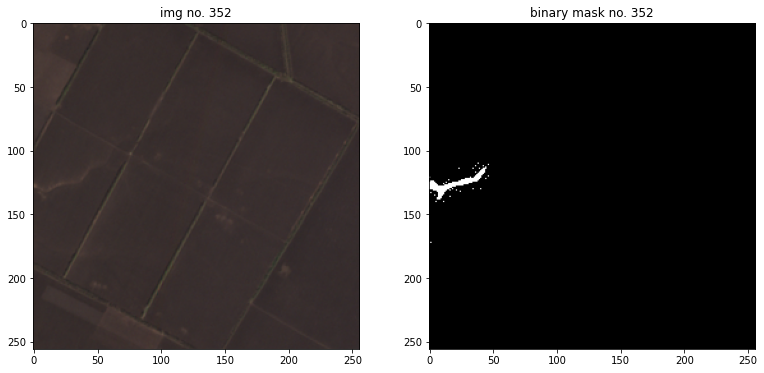

In [8]:
mask_num = np.random.choice(range(0, len(used_masks)))
tile_image = cv2.imread(IMAGES_PATH + used_image_names[mask_num])
tile_mask = cv2.imread(MASKS_PATH + used_masks[mask_num], cv2.IMREAD_GRAYSCALE)

fig, axes = plt.subplots(1, 2, figsize=(13,6))
axes[0].imshow(tile_image)
axes[0].set(title=f"img no. {mask_num}")
axes[0].grid(False)
axes[1].imshow(tile_mask, 'gray')
axes[1].set(title=f"binary mask no. {mask_num}")
axes[1].grid(False)
plt.show()

using U-Net (convolutional neural network) from https://www.depends-on-the-definition.com/unet-keras-segmenting-images/

In [9]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [10]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [11]:
# Set some parameters
im_width = 256
im_height = 256
border = 5

In [12]:
paths_train = list(zip(used_image_names, used_masks))
len(paths_train)

401

In [13]:
paths_train[:2]

[('T36UXV_20200406T083559_TCI_10m_18_8.png', 'train_18_8.png'),
 ('T36UXV_20200406T083559_TCI_10m_18_13.png', 'train_18_13.png')]

In [14]:
# Get and resize train images and masks
def get_data(paths, train=True):
    # ids = next(os.walk(path + "images"))[2]
    X = np.zeros((len(paths), im_height, im_width, 1), dtype=np.float32)
    if train:
        y = np.zeros((len(paths), im_height, im_width, 1), dtype=np.float32)
    print('Getting and resizing images ... ')
    for n, (img_path, msk_path) in tqdm_notebook(enumerate(paths), total=len(paths)):
        # Load images
        img = load_img(IMAGES_PATH + img_path, grayscale=True)
        x_img = img_to_array(img)
        x_img = resize(x_img, (im_height, im_width, 1), mode='constant', preserve_range=True)

        # Load masks
        if train:
            mask = img_to_array(load_img(MASKS_PATH + msk_path, grayscale=True))
            mask = resize(mask, (im_height, im_width, 1), mode='constant', preserve_range=True)

        # Save images
        X[n, ..., 0] = x_img.squeeze() / 255
        if train:
            y[n] = mask / 255
    print('Done!')
    if train:
        return X, y
    else:
        return X
    
X, y = get_data(paths_train, train=True)

Getting and resizing images ... 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/401 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


Done!


In [15]:
# Split train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=2018)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: No contour levels were found within the data range.
  if __name__ == '__main__':


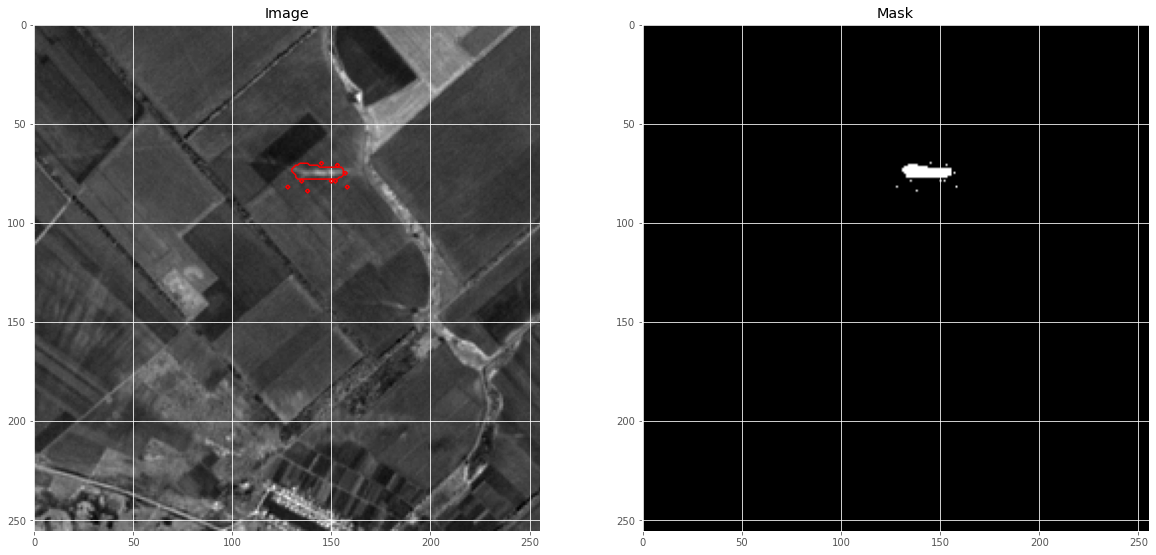

In [16]:
# Check if training data looks all right
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].imshow(X_train[ix, ..., 0], cmap='gray')
if has_mask:
    ax[0].contour(y_train[ix].squeeze(), colors='r', levels=[0.5])
ax[0].set_title('Image')

ax[1].imshow(y_train[ix].squeeze(), interpolation='bilinear', cmap='gray')
ax[1].set_title('Mask');

In [17]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

In [18]:
def get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True):
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [19]:
input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)

model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=[tf.keras.metrics.BinaryIoU(target_class_ids=[0], threshold=0.5)])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  160         ['img[0][0]']                    
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [20]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-tgs-salt.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [21]:
results = model.fit(X_train, y_train, batch_size=16, epochs=20, callbacks=callbacks,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
20/20 [==============================] - ETA: 0s - loss: 0.2901 - binary_io_u: 0.9826
Epoch 1: val_loss improved from inf to 0.58656, saving model to model-tgs-salt.h5
20/20 [==============================] - 23s 273ms/step - loss: 0.2901 - binary_io_u: 0.9826 - val_loss: 0.5866 - val_binary_io_u: 0.8902 - lr: 0.0010
Epoch 2/20
20/20 [==============================] - ETA: 0s - loss: 0.1665 - binary_io_u: 0.9987
Epoch 2: val_loss improved from 0.58656 to 0.17310, saving model to model-tgs-salt.h5
20/20 [==============================] - 4s 204ms/step - loss: 0.1665 - binary_io_u: 0.9987 - val_loss: 0.1731 - val_binary_io_u: 0.9985 - lr: 0.0010
Epoch 3/20
20/20 [==============================] - ETA: 0s - loss: 0.1149 - binary_io_u: 0.9998
Epoch 3: val_loss did not improve from 0.17310
20/20 [==============================] - 4s 197ms/step - loss: 0.1149 - binary_io_u: 0.9998 - val_loss: 4.8870 - val_binary_io_u: 0.1241 - lr: 0.0010
Epoch 4/20
20/20 [=========================

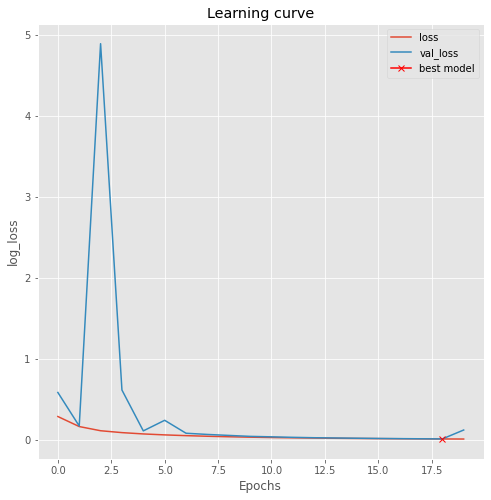

In [22]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [23]:
# Load best model
model.load_weights('model-tgs-salt.h5')

In [24]:
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_valid, y_valid, verbose=1)

3/3 [==============================] - 3s 607ms/step - loss: 0.0140 - binary_io_u: 1.0000


[0.014048739336431026, 1.0]

In [25]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

3/3 [==============================] - 1s 89ms/step


In [38]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='gray')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.3])
    ax[0].set_title('Image')
    ax[0].grid(False)

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Erosion')
    ax[1].grid(False)

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.3])
    ax[2].set_title('Erosion Predicted')
    ax[2].grid(False)
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.3])
    ax[3].set_title('Erosion Predicted binary')
    ax[3].grid(False);

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: No contour levels were found within the data range.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: No contour levels were found within the data range.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: No contour levels were found within the data range.


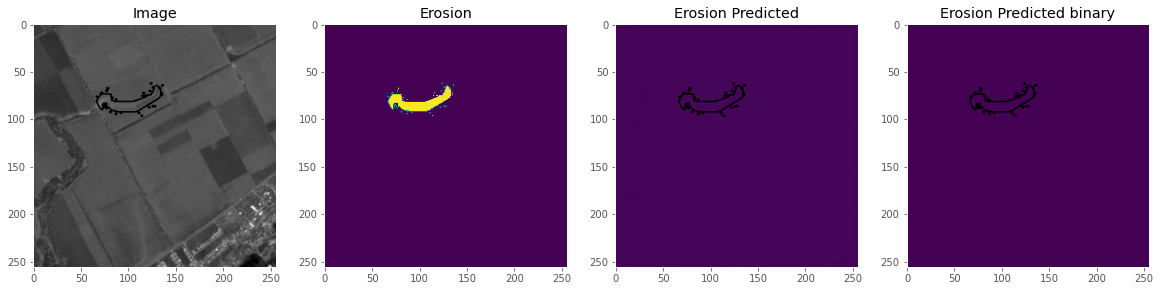

In [39]:
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=None)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: No contour levels were found within the data range.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: No contour levels were found within the data range.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: No contour levels were found within the data range.


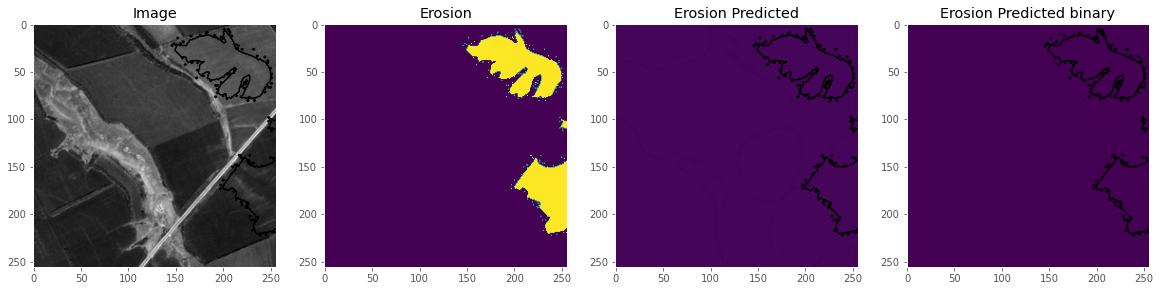

In [43]:
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=None)

One may observe that soil erosion is hardly visible on original image and this it is hard to extract some features in order to predict soil erosion